In [45]:
%matplotlib inline
import pandas as pd
import sys, os
# import soundfile as sf
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import peakutils
import numpy as np
from matplotlib import mlab
import matplotlib.pyplot as plt

sys.path.append('Libraries')
import signal_processing as sl

In [17]:
# data, samplerate = sf.read('recording.wav')
# pd.Series(data).plot()

In [18]:
(rate,sig) = wav.read("recording.wav")
mfcc_feat = mfcc(sig,rate)
mfcc_feat.shape

(7857, 13)

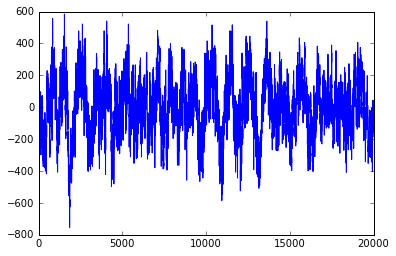

In [19]:
pd.Series(sig[:20000]).plot()

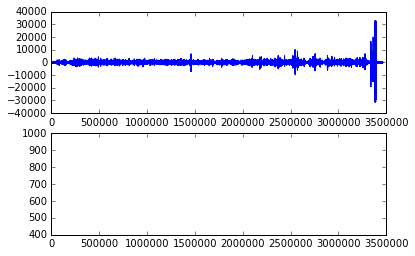

In [34]:


dt = 0.0005
# 100, 400 and 200 Hz sine 'wave'
t = range(len(sig))
x = sig # the signal
NFFT = 1024       # the length of the windowing segments
Fs = int(1.0/dt)  # the sampling frequency

# modified specgram()

# plot
ax1 = plt.subplot(211)
_ = plt.plot(t, x)
_ = plt.subplot(212, sharex=ax1)

# the minfreq and maxfreq args will limit the frequencies 
Pxx, freqs, bins, im = my_specgram(x, NFFT=NFFT, Fs=Fs, noverlap=900, 
                                cmap=plt.cm.Accent, minfreq = 400, maxfreq = 12000)
_ = plt.show()
plt.close()

In [43]:
sN, pN = sig.shape[0], sum_Pxx.shape[0]
sN,pN
pN

(3465168, 27937)

(27937,)

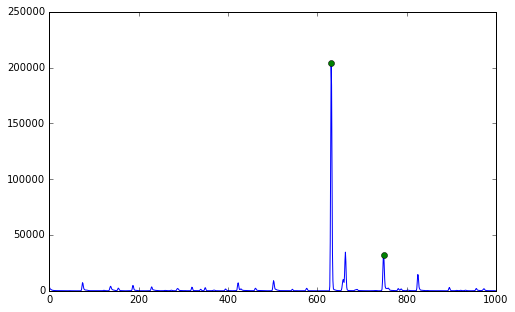

In [38]:
sum_Pxx = Pxx.sum(axis=0)
sum_Pxx.shape
rng = 16937, 17937
sum_Pxx_subset = sum_Pxx[rng[0]:rng[1]]
min_thresh = 8000
max_thresh = 100000
THRESH = .09
MIN_DIST = 50
subset_sound = sig[rng[0]:rng[1]]

indexes = peakutils.indexes(sum_Pxx_subset, thres=THRESH, min_dist=MIN_DIST)

_ = plt.figure(figsize = (8,5))
_ = plt.plot(sum_Pxx_subset)
_ = plt.plot(indexes, sum_Pxx_subset[indexes], 'o')

In [39]:
sig.shape

(3465168,)

In [40]:
wav.write("subset_sound.wav", rate, subset_sound)